In [1]:
%%time
# Imports:

# defaults
import math
import numpy as np
import matplotlib.pyplot as plt
import csv

# torch stuff
import torch
import torch.nn as nn
from torch.optim import Adam, NAdam
from torch.utils.data import TensorDataset, DataLoader

# UNet dependencies
from denoising_diffusion_pytorch import Unet1D # fancy unet
# from functools import partial
# from einops import rearrange, reduce
# from einops.layers.torch import Rearrange

# Smact check dependencies
import smact
from smact.screening import pauling_test
import pandas
import itertools
from fractions import Fraction
import functools
from pymatgen.core.composition import Composition

# Typenotes
from typing import Tuple
from typing import List

# file import
from helper_formula_parse import *
from supercon_wtypes_parse import *
from helper_dataset_shuffle import *
from dataset_creation import *
from helper_reverse_formula import *
# from helper_unet_functions import *
from smact_validity_checks import *
from save_valid_compounds_to_csv import *

CPU times: total: 4.05 s
Wall time: 8.8 s


In [2]:
SUPERCON_DATA_FILE = "SuperCon_with_types.dat"

# element table to set up vectors in R^(1x96): must len(element_table) = 96
element_table = ["H","He","Li","Be","B","C","N","O","F","Ne","Na","Mg","Al","Si","P","S","Cl","Ar","K","Ca","Sc","Ti","V","Cr","Mn","Fe","Co",
              "Ni","Cu","Zn","Ga","Ge","As","Se","Br","Kr","Rb","Sr","Y","Zr","Nb","Mo","Tc","Ru","Rh","Pd","Ag","Cd","In","Sn","Sb","Te",
              "I","Xe","Cs","Ba","La","Ce","Pr","Nd","Pm","Sm","Eu","Gd","Tb","Dy","Ho","Er","Tm","Yb","Lu","Hf","Ta","W","Re","Os","Ir",
              "Pt","Au","Hg","Tl","Pb","Bi","Po","At","Rn","Fr","Ra","Ac","Th","Pa","U","Np","Pu","Am","Cm"]

# validate table correctness
validation_element_table = ["H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca",
                            "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Kr", "Rb", "Sr","Y",
                            "Zr","Nb","Mo","Tc","Ru","Rh","Pd","Ag","Cd","In","Sn","Sb","Te","I","Xe","Cs","Ba","La","Ce","Pr","Nd","Pm",
                            "Sm","Eu","Gd","Tb","Dy","Ho","Er","Tm","Yb","Lu","Hf","Ta","W","Re","Os","Ir","Pt","Au","Hg","Tl","Pb" ,"Bi" ,
                            "Po" ,"At" ,"Rn" ,"Fr" ,"Ra" ,"Ac" ,"Th" ,"Pa" ,"U" ,"Np" ,"Pu" ,"Am" ,"Cm"]

assert(len(element_table) == 96)
print("NOTE: Correct element table length.")

assert(validation_element_table == element_table)
print("NOTE: Valid table.")

NOTE: Correct element table length.
NOTE: Valid table.


In [3]:
returned_datasets = prepare_datasets_for_classes(SUPERCON_DATA_FILE, element_table, 1/20, True)

torch.Size([16708, 96])
torch.Size([7589, 96])
torch.Size([1440, 96])
torch.Size([7679, 96])
Train Data Size: 15873 | Test Data Size: 835
Train Data Size: 7210 | Test Data Size: 379
Train Data Size: 1368 | Test Data Size: 72
Train Data Size: 7296 | Test Data Size: 383


In [4]:
# Unpack the list into individual variables (if needed)
torch_diffusion_data_raw_unconditional_train = returned_datasets[0]
torch_diffusion_data_raw_cuprates_train = returned_datasets[1]
torch_diffusion_data_raw_pnictides_train = returned_datasets[2]
torch_diffusion_data_raw_others_train = returned_datasets[3]

torch_diffusion_data_raw_unconditional_test = returned_datasets[4]
torch_diffusion_data_raw_cuprates_test = returned_datasets[5]
torch_diffusion_data_raw_pnictides_test = returned_datasets[6]
torch_diffusion_data_raw_others_test = returned_datasets[7]

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"NOTE: Using Device: \"{device}\"","|",(f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

NOTE: Using Device: "cuda:0" | NVIDIA GeForce RTX 3060 Ti


In [6]:
def get_named_beta_schedule(schedule_name: str, num_diffusion_timesteps: int) -> torch.Tensor:
    """
    Get a pre-defined beta schedule for the given name. 
    Function adapted from https://github.com/openai/improved-diffusion/blob/main/improved_diffusion/gaussian_diffusion.py
    Improved support for PyTorch.

    :param schedule_name: The name of the beta schedule.
    :param num_diffusion_timesteps: The number of diffusion timesteps.
    :return: The beta schedule tensor.
    :rtype: torch.Tensor[torch.float64]
    """
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return torch.linspace(
            beta_start, beta_end, num_diffusion_timesteps
        ).to(torch.float64)
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")


In [7]:
def betas_for_alpha_bar(num_diffusion_timesteps: int, alpha_bar: float, max_beta=0.999) -> torch.Tensor:
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumprod of (1-beta) over time from t = [0,1].
    
    Function adapted from https://github.com/openai/improved-diffusion/blob/main/improved_diffusion/gaussian_diffusion.py
    Improved support for PyTorch.

    :param num_diffusion_timesteps: The number of betas to produce.
    :param alpha_bar: A lambda that takes an argument t from 0 to 1 and produces
                      the cumulative product of (1-beta) up to that part of the
                      diffusion process.
    :param max_beta: The maximum beta to use; use values lower than 1 to prevent
                     singularities (Improved Diffusion Paper).
    :return: The beta schedule tensor.
    :rtype: torch.Tensor[torch.float64]
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return torch.Tensor(betas).to(torch.float64)


In [8]:
class GaussianDiffusion1D:
    """
    Class for Gaussian diffusion of 1D Tensors (vector diffusion).
    Standard pixel-space DDPM diffusion process, extended to work for 1d tensors instead of 2d tensors.
    """

    def __init__(
        self,
        sequence_length: int,
        timesteps: int,
        beta_schedule_type: str
    ):
        """
        Initializes the GaussianDiffusion1D class.

        :param sequence_length: Length of the sequence.
        :param timesteps: Number of timesteps.
        :param beta_schedule_type: Type of beta schedule. Can be "linear" or "cosine".

        :raises TypeError: If the beta schedule type is unknown.
        """
        self.sequence_length = sequence_length
        self.timesteps = timesteps
        self.beta_schedule_type = beta_schedule_type

        if self.beta_schedule_type == "linear":
            self.betas = get_named_beta_schedule(self.beta_schedule_type, self.timesteps)
        elif self.beta_schedule_type == "cosine":
            self.betas = get_named_beta_schedule(self.beta_schedule_type, self.timesteps)
        else:
            raise TypeError(f"{self.beta_schedule_type} is an unknown beta schedule type.")

        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, axis=0)

    def forward(
        self,
        x_0: torch.Tensor,
        t: torch.Tensor,
        device: str
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward diffusion process. Adding noise ~ N(0, I) to vectors.

        :param x_0: Original vector of shape (B, C, L).
        :param t: Timestep tensor of shape (B,).
        :param device: Device to be used.

        :return: Tuple containing mean tensor and noise tensor.
        """
        epsilon = torch.randn_like(x_0)
        alphas_bar_t = self.extract(self.alphas_bar, t, x_0.shape)

        mean = torch.sqrt(alphas_bar_t).to(device) * x_0.to(device)
        variance = torch.sqrt((1 - alphas_bar_t)).to(device) * epsilon.to(device)

        return mean + variance, epsilon.to(device)

    @torch.no_grad()
    def backward(
        self,
        x_t: torch.Tensor,
        t: torch.Tensor,
        model: nn.Module,
        **kwargs
    ) -> torch.Tensor:
        """
        Calls the model to predict the noise in the image and returns
        the denoised image (x_{t-1}).

        This method corresponds to the "big for loop" in the sampling algorithm (see algorithm 2 from Ho et al.).

        :param x_t: Current image tensor of shape (B, C, L).
        :param t: Timestep tensor of shape (1,).
        :param model: Model used to predict the noise in the image.
        :param **kwargs: Additional arguments to be passed to the model.

        :return: Denoised image tensor of shape (B, C, L).
        """
        betas_t = self.extract(self.betas, t, x_t.shape)
        sqrt_one_minus_alphas_bar_t = self.extract(torch.sqrt(1. - self.alphas_bar), t, x_t.shape)
        sqrt_recip_alphas_t = self.extract(torch.sqrt(1.0 / self.alphas), t, x_t.shape)
        mean = sqrt_recip_alphas_t * (x_t - ((betas_t / sqrt_one_minus_alphas_bar_t) * model(x_t, t, **kwargs)))
        posterior_variance_t = betas_t

        # Applies noise to this image if we are not in the last step yet.
        if t == 0:
            return mean
        else:
            z = torch.randn_like(x_t)
            variance = torch.sqrt(posterior_variance_t) * z
            return mean + variance

    @staticmethod
    def extract(
        values: torch.Tensor,
        t: torch.Tensor,
        x_0_shape: Tuple[int]
    ) -> torch.Tensor:
        """
        Picks the values from `values` according to the indices stored in `t`.

        :param values: Tensor of values to pick from.
        :param t: Index tensor.
        :param x_0_shape: Shape of the original tensor x_0.

        :return: Reshaped tensor with picked values.
        """
        batch_size = t.shape[0]
        vector_to_reshape = values.gather(-1, t.cpu())
        """
        if len(x_shape) - 1 = 2:
        reshape `out` to dims
        (batch_size, 1, 1)
        """
        return vector_to_reshape.reshape(batch_size, *((1,) * (len(x_0_shape) - 1))).to(t.device)


In [9]:
def plot_noise_distribution(noise: torch.Tensor, predicted_noise: torch.Tensor):
    """
    Plot noise distributions to visualize and compare predicted and ground truth noise.
    """
    plt.hist(noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()

In [10]:
DIFFUSION_TIMESTEPS = 1000
diffusion_model = GaussianDiffusion1D(96, DIFFUSION_TIMESTEPS, "cosine")

In [11]:
# Hyperparameters
BATCH_SIZE = 64
NUM_WORKERS = 24 # TODO: test different values - change much bigger actually uses CPU (change to like 12)
NO_EPOCHS = 100
PRINT_FREQUENCY = 10
LR = 1e-4
VERBOSE = True
USE_VALIDATION_SET = True

In [12]:
diffusion_dataset_train = TensorDataset(torch_diffusion_data_raw_cuprates_train)
train_dataloader = DataLoader(diffusion_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)

if USE_VALIDATION_SET == True:
    diffusion_dataset_test = TensorDataset(torch_diffusion_data_raw_cuprates_test)
    test_dataloader = DataLoader(diffusion_dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)

In [13]:
unet = Unet1D(
    dim = 48,
    dim_mults = (1, 2, 3, 6),
    channels = 1
)
unet.to(device)

optimizer = torch.optim.NAdam(unet.parameters(), lr=LR)

---
Epoch: 0 | Train Loss 0.21832559756668551 | Val Loss 0.10669267773628235


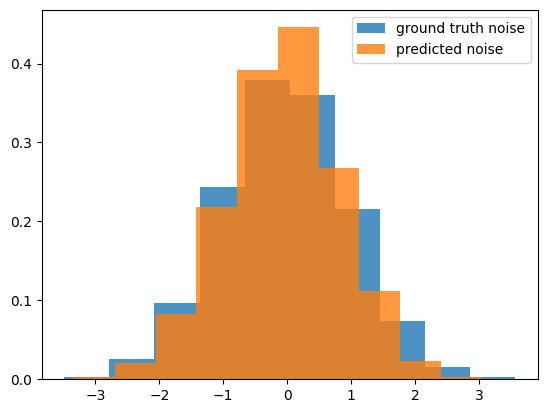

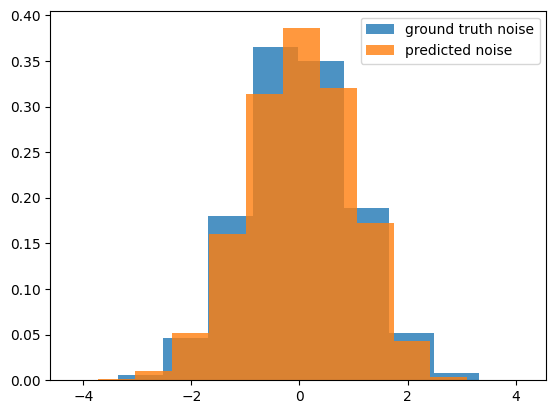

---
Epoch: 9 | Train Loss 0.04207382579001465 | Val Loss 0.036721696704626085


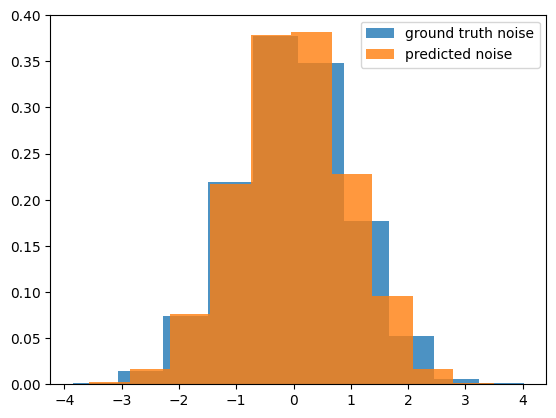

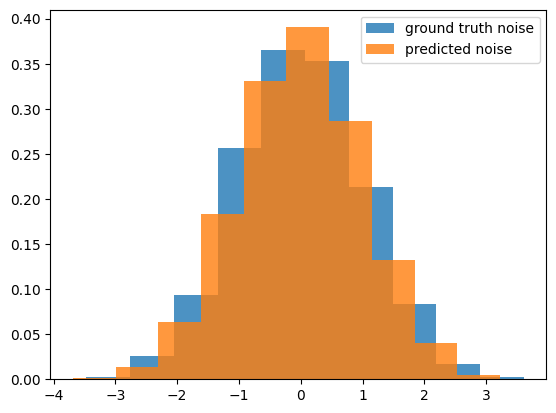

---
Epoch: 19 | Train Loss 0.033356330723368695 | Val Loss 0.031581095233559606


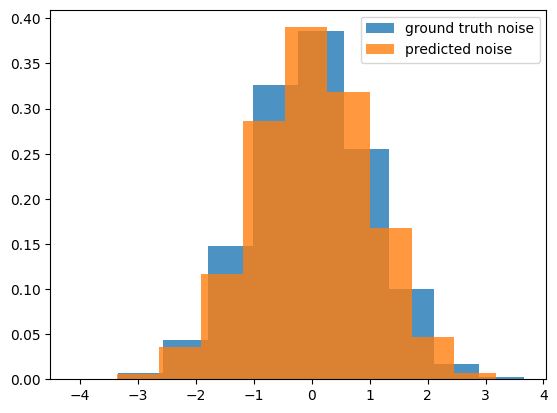

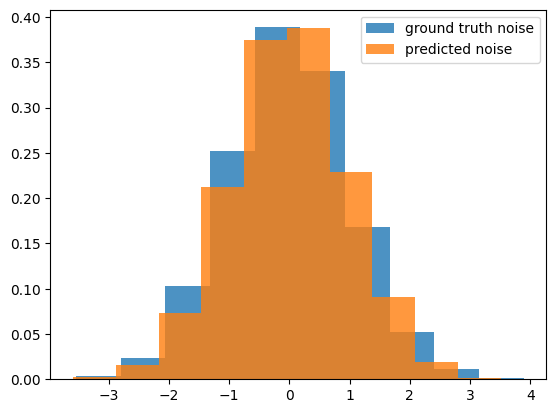

---
Epoch: 29 | Train Loss 0.030723780526646545 | Val Loss 0.032318557053804396


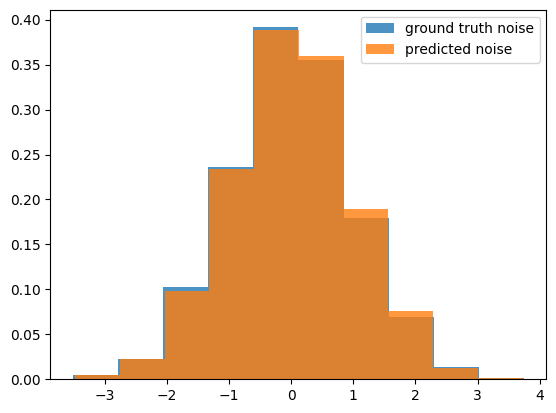

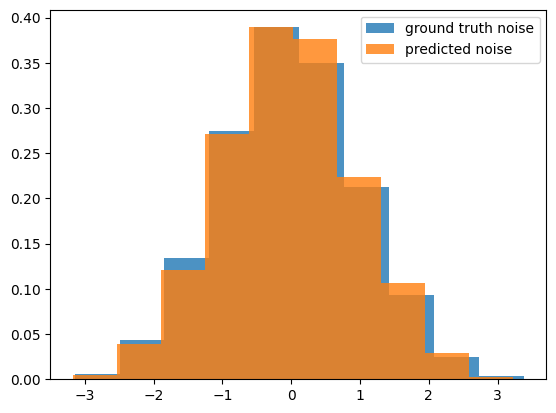

---
Epoch: 39 | Train Loss 0.0285796138591 | Val Loss 0.030641063675284387


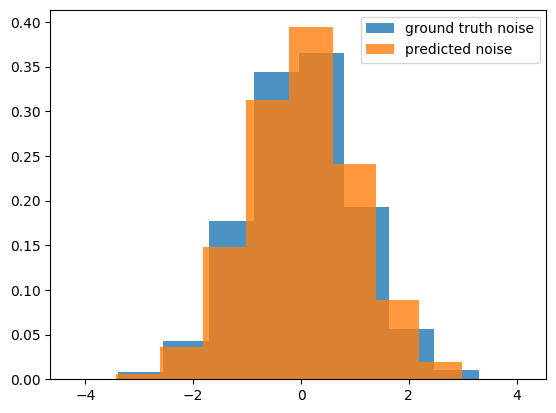

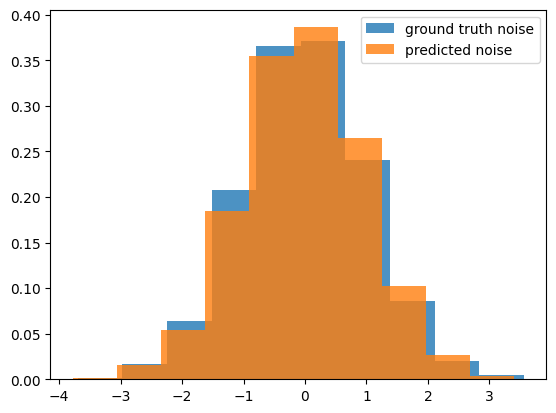

---
Epoch: 49 | Train Loss 0.028274967817456594 | Val Loss 0.030821901559829713


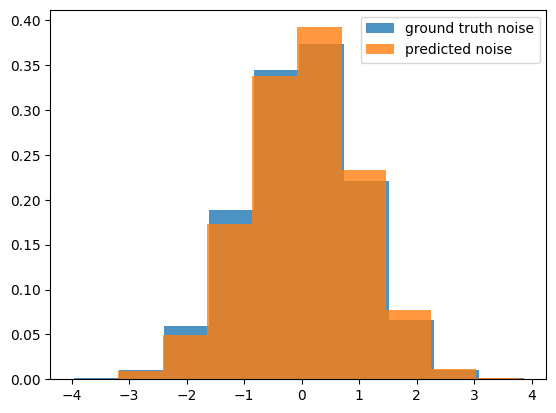

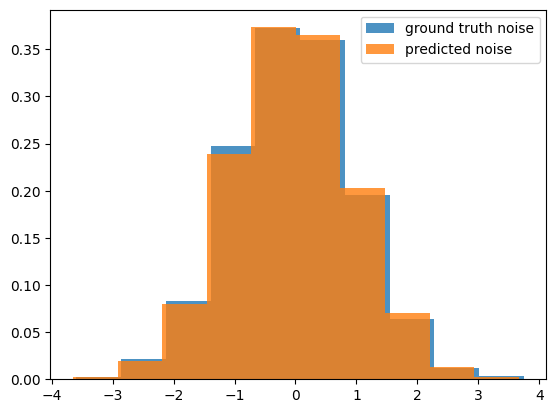

---
Epoch: 59 | Train Loss 0.02637004917154887 | Val Loss 0.025553913787007332


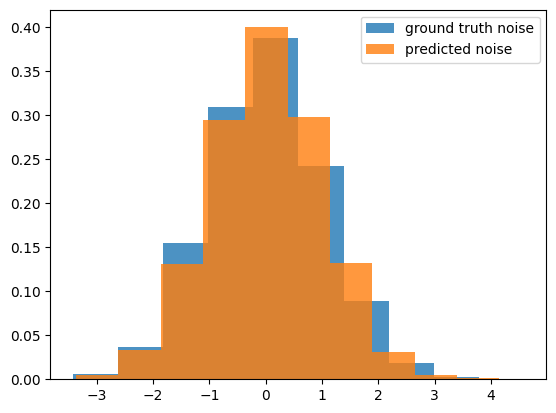

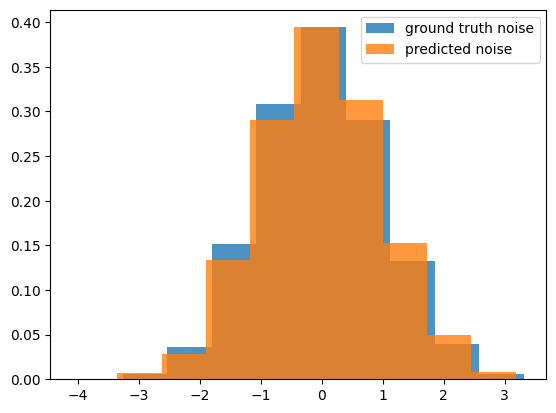

---
Epoch: 69 | Train Loss 0.02565669546103371 | Val Loss 0.024969359487295152


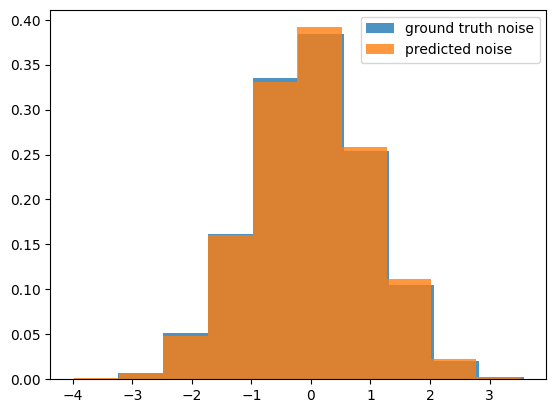

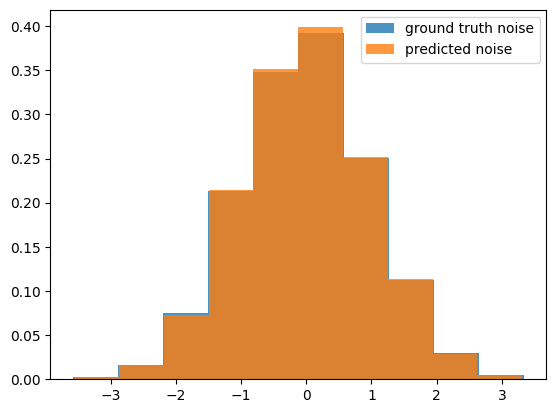

---
Epoch: 79 | Train Loss 0.025279299805073867 | Val Loss 0.024211038276553153


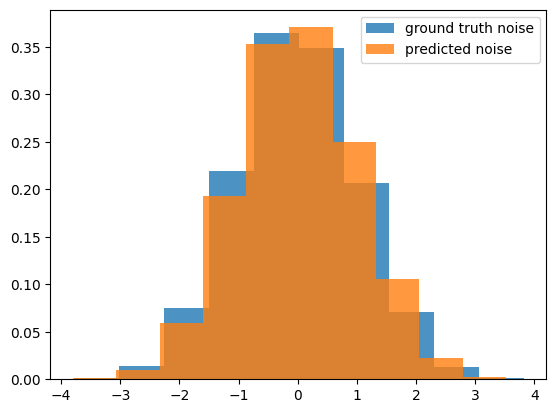

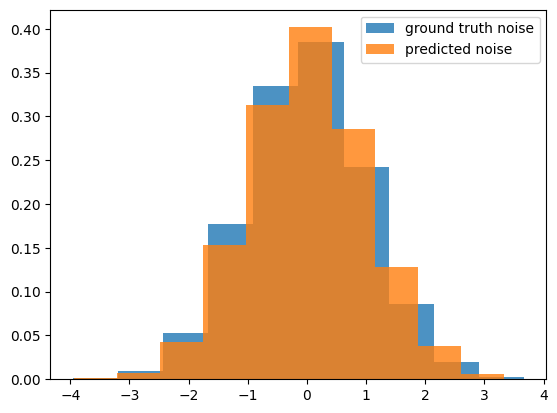

---
Epoch: 89 | Train Loss 0.02470826622032161 | Val Loss 0.02561780475080013


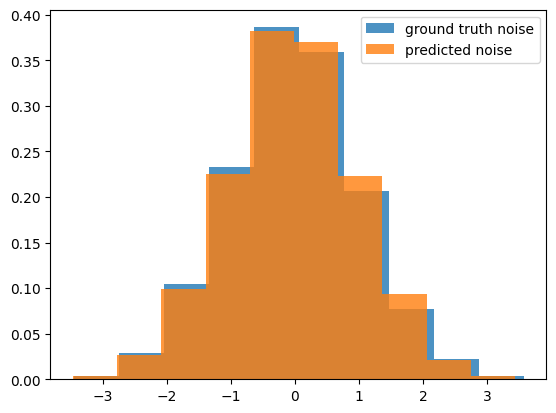

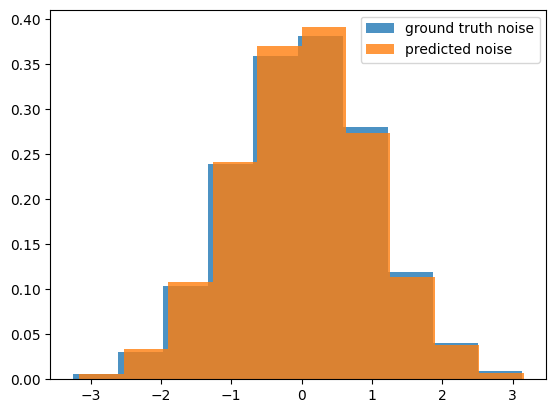

---
Epoch: 99 | Train Loss 0.024031596674051667 | Val Loss 0.024304905161261558


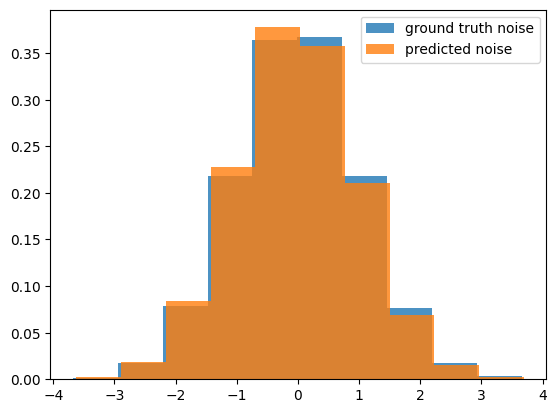

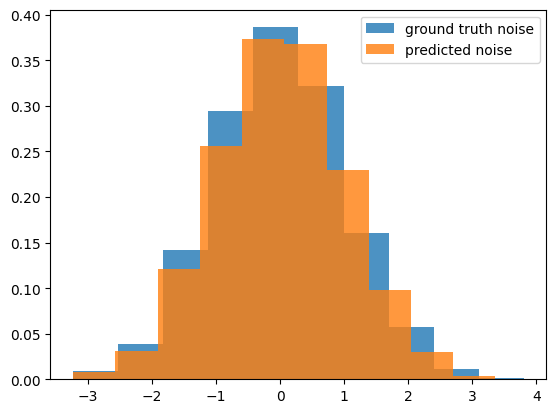

CPU times: total: 11min 40s
Wall time: 30min 23s


In [42]:
%%time
# Training Loop
training_steps_tracker_train = []
training_steps_tracker_val = []
loss_tracker_train = [] # to plot train loss/training step - make sure outside for loop
loss_tracker_val = [] # to plot val loss/training step - make sure outside for loop
epoch_tracker = []
loss_tracker_train_epoch = [] # to plot train loss/epoch - make sure outside for loop
loss_tracker_val_epoch = [] # to plot val loss/epoch - make sure outside for loop
for epoch in range(NO_EPOCHS):
    mean_epoch_loss_train = [] # put in for loop - wipe clean each time
    mean_epoch_loss_val = [] # put in for loop - wipe clean each time

    # on train dataset
    for batch in train_dataloader:
        # sample t from uniform distribution of 1 to T
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch_train = batch[0].unsqueeze(1).to(device)

        noisy_batch_train, gt_noise_train = diffusion_model.forward(batch_train, t, device)
        predicted_noise_train = unet(noisy_batch_train.to(torch.float32), t)

        optimizer.zero_grad()
        # loss(pred, target)
        loss = torch.nn.functional.mse_loss(predicted_noise_train, gt_noise_train)
        loss_tracker_train.append(loss.item())
        training_steps_tracker_train.append(1)
        mean_epoch_loss_train.append(loss.item())
        loss.backward()
        optimizer.step()

    if USE_VALIDATION_SET == True:
        # on test dataset
        for batch in test_dataloader:
            t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
            batch_val = batch[0].unsqueeze(1).to(device)

            noisy_batch_val, gt_noise_val = diffusion_model.forward(batch_val, t, device)
            predicted_noise_val = unet(noisy_batch_val.to(torch.float32), t)

            loss = torch.nn.functional.mse_loss(predicted_noise_val, gt_noise_val)
            loss_tracker_train.append(loss.item())
            training_steps_tracker_val.append(1)
            mean_epoch_loss_val.append(loss.item())

    epoch_tracker.append(epoch)
    loss_tracker_train_epoch.append(np.mean(mean_epoch_loss_train))
    if USE_VALIDATION_SET == True:
        loss_tracker_val_epoch.append(np.mean(mean_epoch_loss_val))

    # print loss(s)
    if epoch == 0 or epoch % PRINT_FREQUENCY == 9:
        print('---')
        if USE_VALIDATION_SET == True:
            print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss_train)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        else:
            print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss_train)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_distribution(gt_noise_train, predicted_noise_train)
                if USE_VALIDATION_SET == True:
                    plot_noise_distribution(gt_noise_val, predicted_noise_val)

        torch.save(unet.state_dict(), f"cuprate5_unet_param_{epoch}.pth") # save UNet states - use lowest loss UNet for sampling

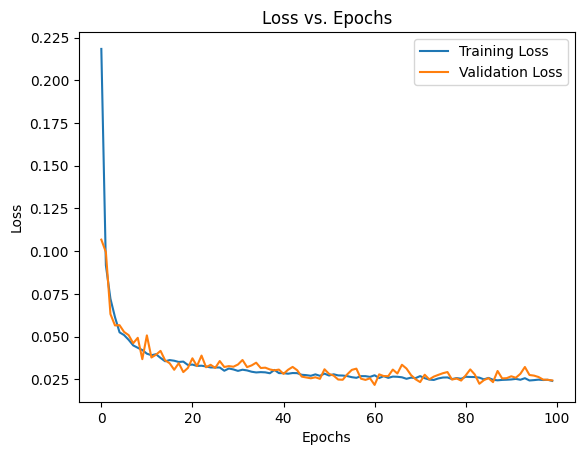

In [43]:
# Plot Loss(s) vs epochs

# Plot and label the training and validation loss values
plt.plot(epoch_tracker, loss_tracker_train_epoch, label='Training Loss')
# plt.plot(epochs, loss_tracker_val, label='Validation Loss')
if USE_VALIDATION_SET:
    plt.plot(epoch_tracker, loss_tracker_val_epoch, label='Validation Loss')

# Add in a title and axes labels
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
# plt.xticks(arange(0, len(loss_tracker_train) + 1, 100))

# # Display the plot
plt.legend(loc='best')
plt.show()

In [14]:
# LATER
unet = Unet1D(
    dim = 48,
    dim_mults = (1, 2, 3, 6),
    channels = 1
)
unet.to(device)
unet.load_state_dict(torch.load(("cuprate5_unet_param_69.pth")))

<All keys matched successfully>

In [15]:
# This code was taken from: https://github.com/jychoi118/ilvr_adm/blob/main/resizer.py
import numpy as np
import torch
from math import pi
from torch import nn


class Resizer(nn.Module):
    def __init__(self, in_shape, scale_factor=None, output_shape=None, kernel=None, antialiasing=True):
        super(Resizer, self).__init__()

        # First standardize values and fill missing arguments (if needed) by deriving scale from output shape or vice versa
        scale_factor, output_shape = self.fix_scale_and_size(in_shape, output_shape, scale_factor)

        # Choose interpolation method, each method has the matching kernel size
        method, kernel_width = {
            "cubic": (cubic, 4.0),
            "lanczos2": (lanczos2, 4.0),
            "lanczos3": (lanczos3, 6.0),
            "box": (box, 1.0),
            "linear": (linear, 2.0),
            None: (cubic, 4.0)  # set default interpolation method as cubic
        }.get(kernel)

        # Antialiasing is only used when downscaling
        antialiasing *= (np.any(np.array(scale_factor) < 1))

        # Sort indices of dimensions according to scale of each dimension. since we are going dim by dim this is efficient
        sorted_dims = np.argsort(np.array(scale_factor))
        self.sorted_dims = [int(dim) for dim in sorted_dims if scale_factor[dim] != 1]

        # Iterate over dimensions to calculate local weights for resizing and resize each time in one direction
        field_of_view_list = []
        weights_list = []
        for dim in self.sorted_dims:
            # for each coordinate (along 1 dim), calculate which coordinates in the input image affect its result and the
            # weights that multiply the values there to get its result.
            weights, field_of_view = self.contributions(in_shape[dim], output_shape[dim], scale_factor[dim], method,
                                                        kernel_width, antialiasing)

            # convert to torch tensor
            weights = torch.tensor(weights.T, dtype=torch.float32)

            # We add singleton dimensions to the weight matrix so we can multiply it with the big tensor we get for
            # tmp_im[field_of_view.T], (bsxfun style)
            weights_list.append(
                nn.Parameter(torch.reshape(weights, list(weights.shape) + (len(scale_factor) - 1) * [1]),
                             requires_grad=False))
            field_of_view_list.append(
                nn.Parameter(torch.tensor(field_of_view.T.astype(np.int32), dtype=torch.long), requires_grad=False))

        self.field_of_view = nn.ParameterList(field_of_view_list)
        self.weights = nn.ParameterList(weights_list)

    def forward(self, in_tensor):
        x = in_tensor

        # Use the affecting position values and the set of weights to calculate the result of resizing along this 1 dim
        for dim, fov, w in zip(self.sorted_dims, self.field_of_view, self.weights):
            # To be able to act on each dim, we swap so that dim 0 is the wanted dim to resize
            x = torch.transpose(x, dim, 0)

            # This is a bit of a complicated multiplication: x[field_of_view.T] is a tensor of order image_dims+1.
            # for each pixel in the output-image it matches the positions the influence it from the input image (along 1 dim
            # only, this is why it only adds 1 dim to 5the shape). We then multiply, for each pixel, its set of positions with
            # the matching set of weights. we do this by this big tensor element-wise multiplication (MATLAB bsxfun style:
            # matching dims are multiplied element-wise while singletons mean that the matching dim is all multiplied by the
            # same number
            x = torch.sum(x[fov] * w, dim=0)

            # Finally we swap back the axes to the original order
            x = torch.transpose(x, dim, 0)

        return x

    def fix_scale_and_size(self, input_shape, output_shape, scale_factor):
        # First fixing the scale-factor (if given) to be standardized the function expects (a list of scale factors in the
        # same size as the number of input dimensions)
        if scale_factor is not None:
            # By default, if scale-factor is a scalar we assume 2d resizing and duplicate it.
            if np.isscalar(scale_factor) and len(input_shape) > 1:
                scale_factor = [scale_factor, scale_factor]

            # We extend the size of scale-factor list to the size of the input by assigning 1 to all the unspecified scales
            scale_factor = list(scale_factor)
            scale_factor = [1] * (len(input_shape) - len(scale_factor)) + scale_factor

        # Fixing output-shape (if given): extending it to the size of the input-shape, by assigning the original input-size
        # to all the unspecified dimensions
        if output_shape is not None:
            output_shape = list(input_shape[len(output_shape):]) + list(np.uint(np.array(output_shape)))

        # Dealing with the case of non-give scale-factor, calculating according to output-shape. note that this is
        # sub-optimal, because there can be different scales to the same output-shape.
        if scale_factor is None:
            scale_factor = 1.0 * np.array(output_shape) / np.array(input_shape)

        # Dealing with missing output-shape. calculating according to scale-factor
        if output_shape is None:
            output_shape = np.uint(np.ceil(np.array(input_shape) * np.array(scale_factor)))

        return scale_factor, output_shape

    def contributions(self, in_length, out_length, scale, kernel, kernel_width, antialiasing):
        # This function calculates a set of 'filters' and a set of field_of_view that will later on be applied
        # such that each position from the field_of_view will be multiplied with a matching filter from the
        # 'weights' based on the interpolation method and the distance of the sub-pixel location from the pixel centers
        # around it. This is only done for one dimension of the image.

        # When anti-aliasing is activated (default and only for downscaling) the receptive field is stretched to size of
        # 1/sf. this means filtering is more 'low-pass filter'.
        fixed_kernel = (lambda arg: scale * kernel(scale * arg)) if antialiasing else kernel
        kernel_width *= 1.0 / scale if antialiasing else 1.0

        # These are the coordinates of the output image
        out_coordinates = np.arange(1, out_length + 1)

        # since both scale-factor and output size can be provided simulatneously, perserving the center of the image requires shifting
        # the output coordinates. the deviation is because out_length doesn't necesary equal in_length*scale.
        # to keep the center we need to subtract half of this deivation so that we get equal margins for boths sides and center is preserved.
        shifted_out_coordinates = out_coordinates - (out_length - in_length * scale) / 2

        # These are the matching positions of the output-coordinates on the input image coordinates.
        # Best explained by example: say we have 4 horizontal pixels for HR and we downscale by SF=2 and get 2 pixels:
        # [1,2,3,4] -> [1,2]. Remember each pixel number is the middle of the pixel.
        # The scaling is done between the distances and not pixel numbers (the right boundary of pixel 4 is transformed to
        # the right boundary of pixel 2. pixel 1 in the small image matches the boundary between pixels 1 and 2 in the big
        # one and not to pixel 2. This means the position is not just multiplication of the old pos by scale-factor).
        # So if we measure distance from the left border, middle of pixel 1 is at distance d=0.5, border between 1 and 2 is
        # at d=1, and so on (d = p - 0.5).  we calculate (d_new = d_old / sf) which means:
        # (p_new-0.5 = (p_old-0.5) / sf)     ->          p_new = p_old/sf + 0.5 * (1-1/sf)
        match_coordinates = shifted_out_coordinates / scale + 0.5 * (1 - 1 / scale)

        # This is the left boundary to start multiplying the filter from, it depends on the size of the filter
        left_boundary = np.floor(match_coordinates - kernel_width / 2)

        # Kernel width needs to be enlarged because when covering has sub-pixel borders, it must 'see' the pixel centers
        # of the pixels it only covered a part from. So we add one pixel at each side to consider (weights can zeroize them)
        expanded_kernel_width = np.ceil(kernel_width) + 2

        # Determine a set of field_of_view for each each output position, these are the pixels in the input image
        # that the pixel in the output image 'sees'. We get a matrix whos horizontal dim is the output pixels (big) and the
        # vertical dim is the pixels it 'sees' (kernel_size + 2)
        field_of_view = np.squeeze(
            np.int16(np.expand_dims(left_boundary, axis=1) + np.arange(expanded_kernel_width) - 1))

        # Assign weight to each pixel in the field of view. A matrix whos horizontal dim is the output pixels and the
        # vertical dim is a list of weights matching to the pixel in the field of view (that are specified in
        # 'field_of_view')
        weights = fixed_kernel(1.0 * np.expand_dims(match_coordinates, axis=1) - field_of_view - 1)

        # Normalize weights to sum up to 1. be careful from dividing by 0
        sum_weights = np.sum(weights, axis=1)
        sum_weights[sum_weights == 0] = 1.0
        weights = 1.0 * weights / np.expand_dims(sum_weights, axis=1)

        # We use this mirror structure as a trick for reflection padding at the boundaries
        mirror = np.uint(np.concatenate((np.arange(in_length), np.arange(in_length - 1, -1, step=-1))))
        field_of_view = mirror[np.mod(field_of_view, mirror.shape[0])]

        # Get rid of  weights and pixel positions that are of zero weight
        non_zero_out_pixels = np.nonzero(np.any(weights, axis=0))
        weights = np.squeeze(weights[:, non_zero_out_pixels])
        field_of_view = np.squeeze(field_of_view[:, non_zero_out_pixels])

        # Final products are the relative positions and the matching weights, both are output_size X fixed_kernel_size
        return weights, field_of_view


# These next functions are all interpolation methods. x is the distance from the left pixel center


def cubic(x):
    absx = np.abs(x)
    absx2 = absx ** 2
    absx3 = absx ** 3
    return ((1.5 * absx3 - 2.5 * absx2 + 1) * (absx <= 1) +
            (-0.5 * absx3 + 2.5 * absx2 - 4 * absx + 2) * ((1 < absx) & (absx <= 2)))


def lanczos2(x):
    return (((np.sin(pi * x) * np.sin(pi * x / 2) + np.finfo(np.float32).eps) /
             ((pi ** 2 * x ** 2 / 2) + np.finfo(np.float32).eps))
            * (abs(x) < 2))


def box(x):
    return ((-0.5 <= x) & (x < 0.5)) * 1.0


def lanczos3(x):
    return (((np.sin(pi * x) * np.sin(pi * x / 3) + np.finfo(np.float32).eps) /
             ((pi ** 2 * x ** 2 / 3) + np.finfo(np.float32).eps))
            * (abs(x) < 3))


def linear(x):
    return (x + 1) * ((-1 <= x) & (x < 0)) + (1 - x) * ((0 <= x) & (x <= 1))

In [16]:
def Phi1D(vectors, scale_factor, device):
    """
    Phi_N linear low pass filtering operation function proposed in ILVR paper.
    
    :param vectors: vectors input to be changed
    :param scale_factor: N, the scale factor
    
    :return: 
    """
    output_vector = torch.empty((0,)).to(device)
    
    assert vectors.size(2) == diffusion_model.sequence_length
    
    for i in range(vectors.size(0)):
        operation_vector = vectors[i]
        resized_vector = operation_vector.repeat(96, 1).unsqueeze(0)
    
        shape = (1, 1, resized_vector.size(1), resized_vector.size(2))
        shape_d = (1, 1, int(resized_vector.size(1) / scale_factor), int(resized_vector.size(2) / scale_factor))
        down = Resizer(shape, 1 / scale_factor).to(device)
        up = Resizer(shape_d, scale_factor).to(device)
        resizers = (down, up)
        
        scaled_vector = up(down(resized_vector.unsqueeze(1).to(device))).squeeze()
        scaled_vector = scaled_vector[0].unsqueeze(0)
        output_vector = torch.cat((output_vector, scaled_vector), 0)
    
    return output_vector

In [20]:
"""
Distrontium ruthenate:

Sr2RuO4
"""
sro_set = ["Y1Ba1.4Sr0.6Cu3O6Se0.51"]
sro_set_1 = split_sc_to_vector(merge_sc_char(split_scform_to_char(sro_set[0])), element_table)
# nickelate_set_2 = split_sc_to_vector(merge_sc_char(split_scform_to_char(nickelate_set[1])), element_table)
sro_set_1 = torch.from_numpy(sro_set_1)
# nickelate_set_2 = torch.from_numpy(nickelate_set_2)
# nickelate_set = torch.stack((nickelate_set_1, nickelate_set_2))
sro_set = sro_set_1
print(sro_set)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 3.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5100, 0.0000, 0.0000,
        0.0000, 0.6000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.4000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000], dtype=torch.float64)


In [21]:
print(cform_from_vector(sro_set, element_table))

O6.0Cu3.0Se0.51Sr0.6Y1.0Ba1.4


In [22]:
"""
IVLR Modifications (conditioning set)
"""
# reference_set = []
# TEMP reference_set
reference_set = sro_set.unsqueeze(0)
# PARAMS
VERBOSE_SAMPLING = True
available_scale_factors = (2, 4, 8, 16, 32) # TODO: optimize for 96 max 32
# scale_factors = (4, 48, 16, 32)
# scale_factors = (3, 6, 12, 24)
scale_factors = (2, 3, 4)
NUM_SAMPLE_PER_FACTOR = 1000
NUM_SAMPLE_VECTORS = NUM_SAMPLE_PER_FACTOR * len(scale_factors) * len(reference_set)

In [23]:
print(reference_set.size())

torch.Size([1, 96])


In [24]:
%%time

total_generated_output = torch.empty((0,)).to(device) # ensure that on same device as "vectors"
print(total_generated_output.device.type) # ensure that on same device as "vectors"
print(f"Sampling {int(len(scale_factors)*NUM_SAMPLE_PER_FACTOR)} samples for {int(len(reference_set))} references.")
for i in range(int(len(reference_set))):
    scale_factor_generated_output = torch.empty((0,)).to(device)
    for j in range(int(len(scale_factors))):
        with torch.no_grad():
            vectors = torch.randn(NUM_SAMPLE_PER_FACTOR, 1, diffusion_model.sequence_length).to(device)
            for k in reversed(range(diffusion_model.timesteps)):
                t = torch.full((1,), k, dtype=torch.long, device=device)
                
                """
                Iterative Latent Variable Refinement (IVLR)
                Algorithm Implementation (https://arxiv.org/pdf/2108.02938v2.pdf):
                
                Same DDPM Training (applying conditioning after training)
                Input: Reference Vector $y$: reference_set[i]
                Output: Generated Vector $x$: appended to scale_factor_generated_output
                """
                
                # Represents x'_{t-1}: raw unconditional DDPM proposal
                vectors_prime = diffusion_model.backward(vectors.to(torch.float32), t, unet.eval().to(device))
                
                # Compute y_{t-1} ~ q(y_{t-1}|y): conditional encoding of reference image
                conditional_encoding_vector, _ = diffusion_model.forward(reference_set[i].to(torch.float32), t, device)
                # resize to [B, 1, L]
                conditional_encoding_vector = torch.stack([conditional_encoding_vector.squeeze()]*NUM_SAMPLE_PER_FACTOR).unsqueeze(1)
                # TODO: Make sure t input is correct (size and value)
                # TEMP: SIZE analysis: v' ([16, 1, 96]); y ([1, 1, 96]) stack 16 -> [16, 1, 96]; 
                
                # Compute x_{t-1} <- \phi_{N}(y_{t-1}) + x'_{t-1} - \phi_{N}(x'_{t-1})
                # NOTE: Theoretically, 0 loss should give \phi_{N}(y_{t-1}) = \phi_{N}(x'_{t-1})
                resized_conditional = Phi1D(conditional_encoding_vector, scale_factors[j], device).unsqueeze(1)
                resized_proposal = Phi1D(vectors_prime, scale_factors[j], device).unsqueeze(1)
                vectors = resized_conditional + vectors_prime - resized_proposal
                
                if (VERBOSE_SAMPLING == True) and (k % 50 == 49 or k == diffusion_model.timesteps - 1):
                    print(f"t = {k}")
                    # print(torch.round(vectors[0], decimals = 2))
                    # torch.set_printoptions(precision=2)
                if k == 0:
                    print("t = 0")
                    print(f"Scale Factor: Sample {j+1} out of {len(scale_factors)} complete.")
            
            # concatenate to scale_factor_generated_output
            scale_factor_generated_output = torch.cat((scale_factor_generated_output, vectors), 0)
    
    print(f"Reference Set: Sample {i+1} out of {len(reference_set)} complete.")
    
    # concatenate to total
    total_generated_output = torch.cat((total_generated_output, scale_factor_generated_output), 0)
            
print(f"Sampling Complete. Sampled a total of {int(NUM_SAMPLE_PER_FACTOR*len(scale_factors)*len(reference_set))} vectors.")
                

cuda
Sampling 3000 samples for 1 references.
t = 999
t = 949
t = 899
t = 849
t = 799
t = 749
t = 699
t = 649
t = 599
t = 549
t = 499
t = 449
t = 399
t = 349
t = 299
t = 249
t = 199
t = 149
t = 99
t = 49
t = 0
Scale Factor: Sample 1 out of 3 complete.
t = 999
t = 949
t = 899
t = 849
t = 799
t = 749
t = 699
t = 649
t = 599
t = 549
t = 499
t = 449
t = 399
t = 349
t = 299
t = 249
t = 199
t = 149
t = 99
t = 49
t = 0
Scale Factor: Sample 2 out of 3 complete.
t = 999
t = 949
t = 899
t = 849
t = 799
t = 749
t = 699
t = 649
t = 599
t = 549
t = 499
t = 449
t = 399
t = 349
t = 299
t = 249
t = 199
t = 149
t = 99
t = 49
t = 0
Scale Factor: Sample 3 out of 3 complete.
Reference Set: Sample 1 out of 1 complete.
Sampling Complete. Sampled a total of 3000 vectors.
CPU times: total: 2h 53min 14s
Wall time: 2h 56min 21s


In [25]:
%%time

total_generated_output = total_generated_output.squeeze()
total_generated_output = total_generated_output.unsqueeze(1)

assert(total_generated_output.size() == torch.Size([int(NUM_SAMPLE_PER_FACTOR*len(scale_factors)*len(reference_set)), 1, len(element_table)]))
SHOW_FAULTY_GENERATIONS = False
VERBOSE_GENERATION_PRINTING = False
faulty_sample_count = []
generated_superconductors_raw = []
for i in range(int(NUM_SAMPLE_PER_FACTOR*len(scale_factors)*len(reference_set))):
    raw_generated_vector = torch.round(total_generated_output[i], decimals = 2)
    raw_generated_vector = raw_generated_vector[0]

    """
    Apply threshold filter to remove residual noise.
    """
    # TODO: refine threshold method
    filtered_generated_vector = raw_generated_vector
    threshold = 0.08# Threshold value - keep between [0.01, 0.1]
    mask = torch.abs(filtered_generated_vector) < threshold # Create a mask for values that satisfy the condition
    filtered_generated_vector[mask] = 0.00 # Apply the mask to set the values to 0.00

    torch.set_printoptions(precision=2)

    """
    Get rid of result if has negative element values <-0.1. Too much noise.
    """
    # TODO: if samples with neg values are very noise, examine training process, change timesteps and epochs.
    negative_values_mask = filtered_generated_vector < 0.0 # after mask
    if (True not in negative_values_mask) and (1 < torch.count_nonzero(filtered_generated_vector) < 8):
        sample_faulty = False
        generated_cform = cform_from_vector(filtered_generated_vector, element_table)
        if VERBOSE_GENERATION_PRINTING == True:
            print(generated_cform)
        generated_superconductors_raw.append(generated_cform)
    else:
        sample_faulty = True
        faulty_sample_count.append(1)
        if SHOW_FAULTY_GENERATIONS == True:
            generated_cform = cform_from_vector(filtered_generated_vector, element_table)
            print(f"Faulty Generation: {generated_cform}")

print(f"Excluded {len(faulty_sample_count)} faulty samples.")

Excluded 2088 faulty samples.
CPU times: total: 8.28 s
Wall time: 8.47 s


In [26]:
len(generated_superconductors_raw)

912

In [27]:
print(generated_superconductors_raw)

['O5.98Cu2.99As0.18Se0.32Sr0.57Y1.04Ba1.39', 'O5.99Cu2.96As0.12Se0.37Sr0.62Y0.94Ba1.36', 'O6.01Cu2.99Se0.46Sr0.61Y0.99Ba1.4', 'O6.03Cu3.02As0.29Se0.21Sr0.52Y1.08Ba1.41', 'O6.05Cu3.02As0.26Se0.23Sr0.66Y0.93Ba1.35', 'O6.05Cu2.97As0.18Se0.31Sr0.6Y1.01Ba1.42', 'O6.02Cu3.03As0.1Se0.39Sr0.63Y0.96Ba1.39', 'O6.01Cu3.01As0.2Se0.3Sr0.6Y0.97Ba1.39', 'O5.98Cu3.0As0.11Se0.39Sr0.59Y1.02Ba1.42', 'O5.96Cu3.0Se0.44Sr0.6Y1.01Ba1.4', 'O6.05Cu3.05Se0.44Rb0.24Sr0.34Y1.09Ba1.42', 'O6.04Cu2.93As0.11Se0.38Sr0.66Y0.91Ba1.4', 'O6.03Cu2.95As0.24Se0.26Sr0.6Y1.01Ba1.44', 'O5.97Cu3.02As0.24Se0.26Sr0.6Y1.0Ba1.39', 'O6.0Cu2.94Se0.45Sr0.59Y1.01Ba1.42', 'O6.01Cu2.99As0.33Se0.17Sr0.55Y1.07Ba1.41', 'O6.08Cu2.95As0.17Se0.33Sr0.55Y1.04Ba1.42', 'O6.02Cu3.02As0.18Se0.32Sr0.61Y1.01Ba1.37', 'O6.02Cu2.94As0.16Se0.34Sr0.6Y0.99Ba1.42', 'O5.96Cu3.02As0.31Se0.2Sr0.52Y1.05Ba1.47', 'O6.0Cu3.02As0.29Se0.21Sr0.54Y1.06Ba1.46', 'O6.03Cu3.03Se0.43Sr0.57Y1.03Ba1.42', 'O5.98Cu2.97Se0.47Sr0.54Y1.06Ba1.38', 'O5.99Cu3.03As0.09Se0.4Sr0.55Y1.07B

In [28]:
generated_superconductors_raw = np.array(generated_superconductors_raw)

In [29]:
generated_superconductors_vector_formulas = []
for i in range(np.size(generated_superconductors_raw)):
    split_formula_char = split_scform_to_char(generated_superconductors_raw[i])
    merge_formula_char = merge_sc_char(split_formula_char)
    vector_formula = split_sc_to_vector(merge_formula_char, element_table)
    generated_superconductors_vector_formulas.append(vector_formula)

In [30]:
generated_superconductors_vector_formulas = np.array(generated_superconductors_vector_formulas)

In [31]:
print(np.size(generated_superconductors_vector_formulas, 0))

912


In [32]:
%%time
# uniqueness and novelty test
# find overlap between training data and generated data
overlap = []
for vec1 in generated_superconductors_vector_formulas:
    for vec2 in torch_diffusion_data_raw_cuprates_train.numpy():
        if np.all(np.equal(vec1, vec2)):
            overlap.append(vec1)

overlap = np.array(overlap)

# Find repeating vectors and their counts
unique_vectors, counts = np.unique(generated_superconductors_vector_formulas, axis=0, return_counts=True)

# Get the repeating vectors
repeating_vectors = unique_vectors[counts > 1]

print("Overlapping Vectors:")
print(overlap)
print("Repeating Vectors:")
print(repeating_vectors)

Overlapping Vectors:
[]
Repeating Vectors:
[]
CPU times: total: 18.7 s
Wall time: 18.9 s


In [33]:
np.size(repeating_vectors, 0)

0

In [34]:
print(generated_superconductors_raw)

['O5.98Cu2.99As0.18Se0.32Sr0.57Y1.04Ba1.39'
 'O5.99Cu2.96As0.12Se0.37Sr0.62Y0.94Ba1.36'
 'O6.01Cu2.99Se0.46Sr0.61Y0.99Ba1.4'
 'O6.03Cu3.02As0.29Se0.21Sr0.52Y1.08Ba1.41'
 'O6.05Cu3.02As0.26Se0.23Sr0.66Y0.93Ba1.35'
 'O6.05Cu2.97As0.18Se0.31Sr0.6Y1.01Ba1.42'
 'O6.02Cu3.03As0.1Se0.39Sr0.63Y0.96Ba1.39'
 'O6.01Cu3.01As0.2Se0.3Sr0.6Y0.97Ba1.39'
 'O5.98Cu3.0As0.11Se0.39Sr0.59Y1.02Ba1.42'
 'O5.96Cu3.0Se0.44Sr0.6Y1.01Ba1.4'
 'O6.05Cu3.05Se0.44Rb0.24Sr0.34Y1.09Ba1.42'
 'O6.04Cu2.93As0.11Se0.38Sr0.66Y0.91Ba1.4'
 'O6.03Cu2.95As0.24Se0.26Sr0.6Y1.01Ba1.44'
 'O5.97Cu3.02As0.24Se0.26Sr0.6Y1.0Ba1.39'
 'O6.0Cu2.94Se0.45Sr0.59Y1.01Ba1.42'
 'O6.01Cu2.99As0.33Se0.17Sr0.55Y1.07Ba1.41'
 'O6.08Cu2.95As0.17Se0.33Sr0.55Y1.04Ba1.42'
 'O6.02Cu3.02As0.18Se0.32Sr0.61Y1.01Ba1.37'
 'O6.02Cu2.94As0.16Se0.34Sr0.6Y0.99Ba1.42'
 'O5.96Cu3.02As0.31Se0.2Sr0.52Y1.05Ba1.47'
 'O6.0Cu3.02As0.29Se0.21Sr0.54Y1.06Ba1.46'
 'O6.03Cu3.03Se0.43Sr0.57Y1.03Ba1.42' 'O5.98Cu2.97Se0.47Sr0.54Y1.06Ba1.38'
 'O5.99Cu3.03As0.09Se0.4Sr0.55Y1.07Ba

In [35]:
valid_generated_compounds, valid_generated_compounds_size = filter_for_valid_generated_compounds(generated_superconductors_raw)

270


In [36]:
OUTPUT_FILE = "output_generated_superconductors_12-3.csv"
store_valid_to_csv(valid_generated_compounds, OUTPUT_FILE)

Array has been successfully saved to CSV file.


In [37]:
print(valid_generated_compounds)

['O6.05Cu3.02As0.26Se0.23Sr0.66Y0.93Ba1.35'
 'O6.02Cu3.03As0.1Se0.39Sr0.63Y0.96Ba1.39'
 'O6.04Cu2.93As0.11Se0.38Sr0.66Y0.91Ba1.4'
 'O5.97Cu3.02As0.24Se0.26Sr0.6Y1.0Ba1.39'
 'O6.08Cu2.95As0.17Se0.33Sr0.55Y1.04Ba1.42'
 'O6.02Cu3.02As0.18Se0.32Sr0.61Y1.01Ba1.37'
 'O6.01Cu2.98As0.11Se0.39Sr0.57Y1.03Ba1.43'
 'O6.03Cu3.02As0.1Se0.39Sr0.64Y0.98Ba1.38'
 'O6.04Cu3.0As0.14Se0.36Sr0.53Y1.06Ba1.41'
 'O5.99Cu3.01As0.09Se0.4Sr0.62Y0.99Ba1.39'
 'O6.03Cu3.04As0.11Se0.37Sr0.66Y0.95Ba1.39'
 'O6.01Cu3.0As0.12Se0.38Sr0.63Y0.97Ba1.39'
 'O6.05Cu2.98As0.15Se0.34Sr0.57Y1.01Ba1.44'
 'O6.04Cu3.05As0.08Se0.41Sr0.59Y1.04Ba1.41'
 'O6.07Cu3.04As0.23Se0.27Sr0.58Y1.02Ba1.41'
 'O6.04Cu3.02As0.22Se0.28Sr0.63Y0.98Ba1.4'
 'O6.0Cu3.03As0.25Se0.25Sr0.6Y0.99Ba1.4'
 'O6.04Cu2.96As0.12Se0.38Sr0.57Y1.03Ba1.4'
 'O6.05Cu3.01As0.2Se0.31Sr0.53Y1.07Ba1.42'
 'O6.06Cu2.93As0.12Se0.38Sr0.59Y0.99Ba1.43'
 'O6.02Cu3.05As0.23Se0.27Sr0.53Y1.05Ba1.43'
 'O6.02Cu2.96As0.15Se0.33Sr0.63Y0.98Ba1.38'
 'O6.03Cu2.98As0.26Se0.24Sr0.57Y1.0Ba1.41'
 'O

In [139]:
valid_generated_compounds = valid_generated_compounds
generated_superconductors_vector_formulas = []
for i in range(np.size(valid_generated_compounds)):
    split_formula_char = split_scform_to_char(valid_generated_compounds[i])
    merge_formula_char = merge_sc_char(split_formula_char)
    vector_formula = split_sc_to_vector(merge_formula_char, element_table)
    generated_superconductors_vector_formulas.append(vector_formula)

In [131]:
print(generated_superconductors_vector_formulas)

[array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 2.03, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.44, 0.49, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.21, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.79, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]), array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 2.05, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.39, 0.53, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.18, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,

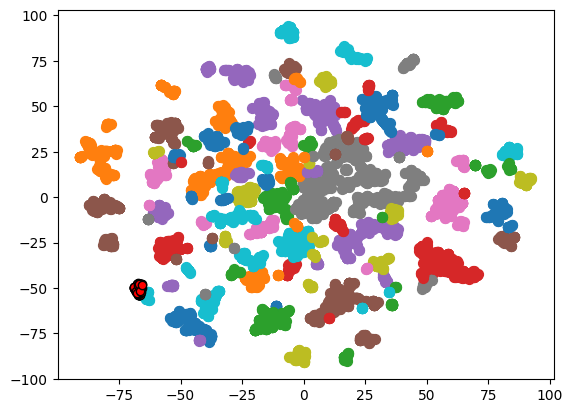

In [141]:

import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Load your dataset and generated outputs
dataset = torch.cat((torch_diffusion_data_raw_others_train, torch_diffusion_data_raw_others_test), 0).numpy()
# generated_outputs = generated_superconductors_vector_formulas
generated_outputs = np.array(generated_superconductors_vector_formulas)

# Combine the dataset and generated outputs into one array
data = np.concatenate((dataset, generated_outputs), axis=0)

# Perform t-SNE clustering
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(data)

# Cluster the t-SNE results for the dataset using DBSCAN
dbscan = DBSCAN(eps=3, min_samples=2)
dbscan.fit(tsne_results[:len(dataset)])
cluster_labels = dbscan.labels_

# Plot the t-SNE results
for cluster in np.unique(cluster_labels):
    if cluster != -1:
        # Plot cluster points with different colors and larger size
        plt.scatter(tsne_results[:len(dataset)][cluster_labels == cluster, 0], tsne_results[:len(dataset)][cluster_labels == cluster, 1], s=50)
plt.scatter(tsne_results[len(dataset):, 0], tsne_results[len(dataset):, 1], facecolors='red', edgecolors='black', label='Generated Outputs')
plt.show()

# # Plot the t-SNE results
# for cluster in np.unique(cluster_labels):
#     if cluster == -1:
#         # Plot noise points as larger black dots
#         plt.scatter(tsne_results[:len(dataset)][cluster_labels == cluster, 0], tsne_results[:len(dataset)][cluster_labels == cluster, 1], color='black', s=50)
#     else:
#         # Plot cluster points with different colors and larger size
#         plt.scatter(tsne_results[:len(dataset)][cluster_labels == cluster, 0], tsne_results[:len(dataset)][cluster_labels == cluster, 1], s=50)
# plt.scatter(tsne_results[len(dataset):, 0], tsne_results[len(dataset):, 1], facecolors='none', edgecolors='black', label='Generated Outputs')
# plt.show()

In [96]:
dataset = torch.from_numpy(dataset)

In [97]:
print(dataset)

tensor([[0.00, 0.00, 0.00,  ..., 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00,  ..., 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.05,  ..., 0.00, 0.00, 0.00],
        ...,
        [0.00, 0.00, 0.00,  ..., 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00,  ..., 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00,  ..., 0.00, 0.00, 0.00]])
